# Generating the 3D version of MNIST

This document explain how to generate an augmented 3D version of MNIST by converting 2D digits to 3D voxel cubes and applying a set of transofmrations like:
- rotation
- RGB coloring
- Gaussian Noise

In [1]:
import os
# turning off annoying tensorflow verbose logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras.datasets import mnist
import numpy as np
import random
import math
import cv2

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

import h5py

## Loading the cannonical MNIST dataset to use as seed.

Loaging MNIST using built-in keras routine:


In [2]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

## Ploting MNIST

Let's check one regular MNIST register:

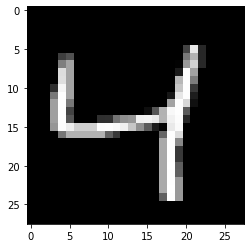

In [3]:
instance = train_x[2]
pyplot.imshow(instance, cmap=pyplot.get_cmap('gray'))
pyplot.show()

## generating 3D digit from 2D

We will stack the original image n times in order to create a 3D grid which is the desired 3D element generated from the 2D original one. A gaussian noise is added to non-zero values in each layer of the stack:

In [4]:
grid = np.zeros((28, 28, 28))

score = instance / 255.0

zero_min = np.zeros((28, 28))
one_max = np.ones((28, 28))

def gaussian_noise(X, sigma):
    ''' adds a gaussian noise limited to 0 and 1 inclusive'''
    X_nonzero_indexes = np.nonzero(X)
    noise = np.random.normal(0, sigma, X.shape)
    copy = X.copy()
    copy[X_nonzero_indexes] = np.minimum(np.maximum(X[X_nonzero_indexes] + 
        noise[X_nonzero_indexes], zero_min[X_nonzero_indexes]), one_max[X_nonzero_indexes])
    return copy

# generating a 3D instance from a 2D image
for z in range(28):
    instance_points = gaussian_noise(score, 0.2)
    grid[:, :, z] = score

## printing one grid

Let's check our progress by drawing the current state of our 3D element

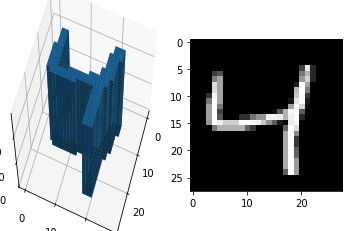

In [5]:
def print_grid_and_image(grid, image):
    fig = pyplot.figure()

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.azim = 20
    ax.dist = 8
    ax.elev = 60
    ax.voxels(grid)

    ax = fig.add_subplot(1, 2, 2)

    ax.imshow(image, cmap=pyplot.get_cmap('gray'))

    pyplot.show()

print_grid_and_image(grid, score)

## Putting some colors on this!

MNIST instances are grayscale 28x28 images. Real life data is colored. Let's put colors in our 3D data using some random python color map:

In [7]:
color_maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 
                'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu']

def convert_to_rgb(gray_image, color_map):
    '''Convert gray image to RGB using the given color map'''
    s_m = pyplot.cm.ScalarMappable(cmap = color_map)
    img_shape = gray_image.shape
    flattened = gray_image.flatten()
    colors = s_m.to_rgba(flattened)
    result = np.zeros(flattened.shape + (3,))

    for i in range(len(flattened)):
        if flattened[i] > 0:
            result[i] = colors[i][:-1]
    return result.reshape(img_shape + (3,))

def create_colored_grid(image, depth, color_map):
    grid = np.zeros(image.shape + (depth, 3,))
    for z in range(depth):
        instance_points = gaussian_noise(image, 0.2)
        rgb_points = convert_to_rgb(instance_points, color_map)
        grid[:, :, z] = rgb_points
    return grid

import random

my_colored_grid = create_colored_grid(score, 28, "viridis")

## plotting 3D digit

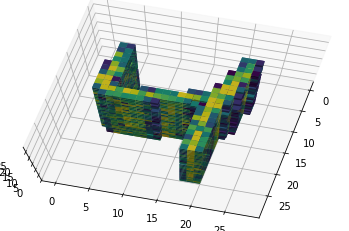

In [8]:
def print_grid(grid):

    grid_shape = grid.shape

    flattened = grid.reshape(((grid_shape[0] * grid_shape[1] * grid_shape[2]), 3))
    voxel_grid_array = np.zeros(len(flattened))

    for i in range(len(flattened)):
        temp = flattened[i]
        if temp[0] > 0 or temp[1] > 0 or temp[2] > 0:
            voxel_grid_array[i] = 1

    voxel_grid = voxel_grid_array.reshape((grid_shape[0], grid_shape[1], grid_shape[2]))

    fig = pyplot.figure()
    ax = fig.add_subplot(projection='3d')
    ax.azim = 15
    ax.dist = 8
    ax.elev = 75
    ax.voxels(voxel_grid, facecolors=grid)

    pyplot.show()

print_grid(my_colored_grid)

## more transformations: reducing size and rotating

Original images in MNIST are 28x28. Dilatting them to generate cubic grids requires a lot of memory and processing.

1 cube size in bytes: 28 x 28 x 28 x 4
60,000 images: ~5GB

After this step, each image will be resized to 16x16.

In addition, each image is also rotated around ijk axes by random small angles

In [9]:
def rotate(grid, z_ang, y_ang, x_ang):

    grid_shape = grid.shape

    result = np.zeros(grid_shape)

    x_lim = grid_shape[0]
    y_lim = grid_shape[1]
    z_lim = grid_shape[2]

    for i in range(x_lim):
        for j in range(y_lim):
            for k in range(z_lim):

                X = i
                Y = j
                Z = k

                if z_ang != 0:
                    x = i - x_lim / 2
                    y = j - y_lim / 2
                    X = int(math.floor(x*math.cos(z_ang) - y*math.sin(z_ang) + x_lim / 2))
                    Y = int(math.floor(x*math.sin(z_ang) + y*math.cos(z_ang) + y_lim / 2)) 

                if y_ang != 0:
                    x = X - x_lim / 2
                    z = Z - z_lim / 2
                    X = int(math.floor(x*math.cos(y_ang) - z*math.sin(y_ang) + x_lim / 2))
                    Z = int(math.floor(x*math.sin(y_ang) + z*math.cos(y_ang) + z_lim / 2)) 

                if x_ang != 0:
                    y = Y - y_lim / 2
                    z = Z - z_lim / 2
                    Y = int(math.floor(y*math.cos(x_ang) - z*math.sin(x_ang) + y_lim / 2))
                    Z = int(math.floor(y*math.sin(x_ang) + z*math.cos(x_ang) + z_lim / 2)) 

                if X >= 0 and Y >= 0 and Z >= 0 and X < x_lim and Y < y_lim and Z < z_lim:
                    result[X, Y, Z] = grid[i, j, k]

    return result

# Generating the full 3D dataset

In [10]:
new_size = 16

rot_in_rad = 20.0 * math.pi / 180.0
half_rot_in_rad = rot_in_rad / 2

def transform_instance(instance):

    resized = cv2.resize(instance, dsize=(new_size, new_size), interpolation=cv2.INTER_CUBIC)

    grid = create_colored_grid(resized / 255.0, new_size, random.choice(color_maps))

    z_rot = rot_in_rad * random.random() * math.pi / 180.0 - half_rot_in_rad
    y_rot = rot_in_rad * random.random() * math.pi / 180.0 - half_rot_in_rad
    x_rot = rot_in_rad * random.random() * math.pi / 180.0 - half_rot_in_rad
    result = rotate(grid, z_rot, y_rot, x_rot)

    return result

train_x_3d = np.zeros((len(train_x), new_size, new_size, new_size, 3))
test_x_3d = np.zeros((len(test_x), new_size, new_size, new_size, 3))
        
for i in range(len(train_x)):
    train_x_3d[i] = transform_instance(train_x[i])

for i in range(len(test_x)):
    test_x_3d[i] = transform_instance(test_x[i])
        

## print some instances

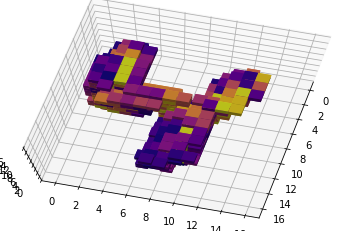

In [12]:

print_grid(train_x_3d[2])

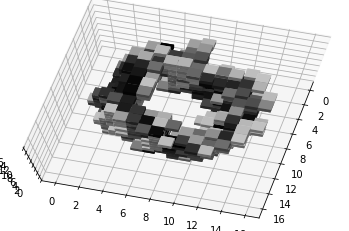

In [13]:
print_grid(train_x_3d[108])

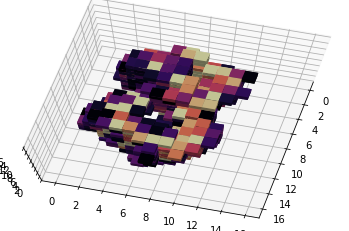

In [14]:
print_grid(train_x_3d[404])

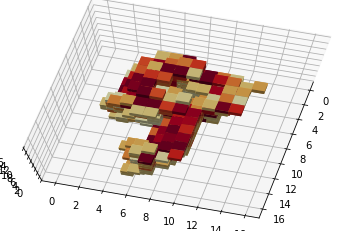

In [15]:
print_grid(test_x_3d[105])

## Exporting to H5

In [134]:
output_file = h5py.File('3d-mnist-luiz.h5', 'w')

output_file.create_dataset('train_x', data=train_x_3d)
output_file.create_dataset('train_y', data=train_y)
output_file.create_dataset('test_x', data=test_x_3d)
output_file.create_dataset('test_y', data=test_y)

output_file.close()